In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.special import softmax, log_softmax
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils

from fitter import Fitter, get_common_distributions

from tqdm import tqdm
import random

# Import P(f_i | C) distributions

In [2]:
#import best fitting distributions and parameters

feature_dists_df = pd.read_csv('feature_dists_df.csv').drop(['Unnamed: 0'], axis=1)
feature_dists_df

,feature,distribution_type,params,label
0,feature_2,beta,"(0.11776839045890578, 149.74182795203535, -2.1...",5
1,feature_4,beta,"(0.2711632488092937, 465.4069516854168, -1.928...",5
2,feature_5,beta,"(0.21602060508177978, 625.918439600516, -4.846...",5
3,feature_6,beta,"(14.256280670273213, 6.9058459231954, 1.454610...",5
4,feature_7,beta,"(0.4894176208554678, 528.8948875881285, -8.432...",5
5,feature_8,beta,"(0.11519992942043017, 197.06722892055205, -4.6...",5
6,feature_9,beta,"(0.3018378051146521, 204.95938188638956, -5.83...",5
7,feature_10,beta,"(14.752993151276618, 6.344337461684533, 0.1954...",5
8,feature_2,beta,"(14.821670613196302, 7.86665989995932, -6.5503...",8
9,feature_4,beta,"(16.236326591296894, 5.212638487058973, -7.674...",8


In [3]:
#create RV objects and store in dicts

feature_dists_5 = {}
feature_dists_8 = {}

for row in feature_dists_df.iterrows():
    row = row[1]
    
    #convert params string into tuple of floats
    params = tuple(map(float, row['params'][1:-1].split(', ')))
    
    #initialize RV objects
    if row['distribution_type']=='beta':
        dist = stats.beta(params[0], params[1], params[2], params[3])
    elif row['distribution_type']=='chi2':
        dist = stats.chi2(params[0], params[1], params[2])
    else:
        print('INVALID DISTRIBUTION TYPE')
        break
    
    #store RV objects in dicts
    if row['label'] == 5:
        feature_dists_5[row['feature']] = dist
    else:
        feature_dists_8[row['feature']] = dist


In [4]:
feature_dists_5

{'feature_2': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fc15722c730>,
 'feature_4': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fc15722c610>,
 'feature_5': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fc15722c820>,
 'feature_6': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fc15722cbe0>,
 'feature_7': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fc15722ce80>,
 'feature_8': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fc15722c580>,
 'feature_9': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fc15722c700>,
 'feature_10': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fc157234640>}

# Get P(f_i) distributions

In [5]:
#import training feature value distributions
train_feature_vals_df = pd.read_csv('hidden_features_df.csv', index_col="Unnamed: 0")
train_feature_vals_df.head()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,8,0.0,11.246423,0.0,7.995950,9.410959,19.745337,9.010060,8.527996,10.110795,19.589340
1,8,0.0,13.312637,0.0,10.743755,11.378502,18.715256,11.810072,11.065614,12.528616,18.708977
2,5,0.0,0.000000,0.0,0.000000,0.000000,28.648830,0.000000,0.000000,0.000000,30.524609
3,5,0.0,0.000000,0.0,0.000000,0.000000,26.991035,0.000000,0.000000,0.000000,29.041384
4,8,0.0,5.038842,0.0,5.323320,5.368689,22.266983,4.806798,4.124915,4.903548,23.818264


In [6]:
# checking if feature_1 and feature_3 have all zeros
counts_feature1 = train_feature_vals_df.groupby('feature_1')['feature_1'].value_counts()
print(counts_feature1)

counts_feature3 = train_feature_vals_df.groupby('feature_3')['feature_3'].value_counts()
print(counts_feature3)

feature_1  feature_1
0.0        0.0          9370
Name: feature_1, dtype: int64
feature_3  feature_3
0.0        0.0          9370
Name: feature_3, dtype: int64


In [7]:
# dropping feature_1 and feature_3
train_feature_vals_df.drop(['feature_1', 'feature_3'], axis=1, inplace=True)

In [8]:
train_feature_vals_df.head()

,label,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,8,11.246423,7.995950,9.410959,19.745337,9.010060,8.527996,10.110795,19.589340
1,8,13.312637,10.743755,11.378502,18.715256,11.810072,11.065614,12.528616,18.708977
2,5,0.000000,0.000000,0.000000,28.648830,0.000000,0.000000,0.000000,30.524609
3,5,0.000000,0.000000,0.000000,26.991035,0.000000,0.000000,0.000000,29.041384
4,8,5.038842,5.323320,5.368689,22.266983,4.806798,4.124915,4.903548,23.818264


In [9]:
#store histograms for each feature in dict
hist_dict = {}

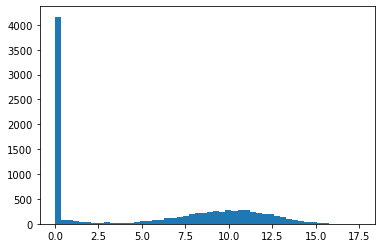

In [10]:
#fit distributionn for feature 2

feature_2 = train_feature_vals_df['feature_2']
feature_2_hist = plt.hist(feature_2, bins=50)
feature_2_hist

#add histogram to hist_dict
hist_dict['feature_2'] = feature_2_hist

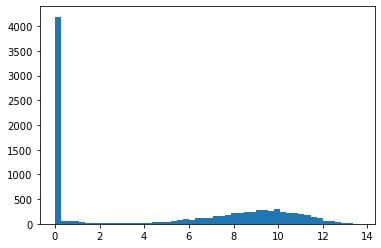

In [11]:
#fit distributionn for feature 4

feature_4 = train_feature_vals_df['feature_4']
feature_4_hist = plt.hist(feature_4, bins=50)
feature_4_hist

#add histogram to hist_dict
hist_dict['feature_4'] = feature_4_hist

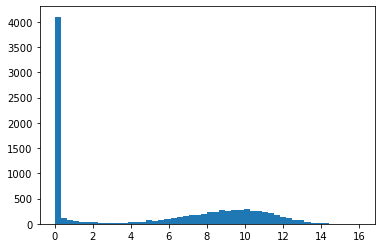

In [12]:
#fit distributionn for feature 5

feature_5 = train_feature_vals_df['feature_5']
feature_5_hist = plt.hist(feature_5, bins=50)
feature_5_hist

#add histogram to hist_dict
hist_dict['feature_5'] = feature_5_hist

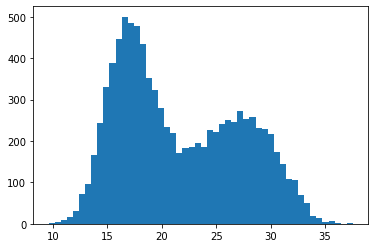

In [13]:
#fit distributionn for feature 6

feature_6 = train_feature_vals_df['feature_6']
feature_6_hist = plt.hist(feature_6, bins=50)
feature_6_hist

#add histogram to hist_dict
hist_dict['feature_6'] = feature_6_hist

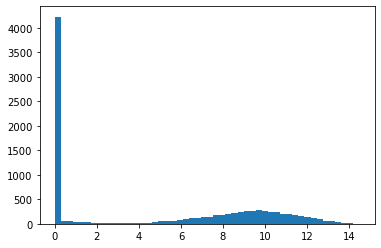

In [14]:
#fit distributionn for feature 7

feature_7 = train_feature_vals_df['feature_7']
feature_7_hist = plt.hist(feature_7, bins=50)
feature_7_hist

#add histogram to hist_dict
hist_dict['feature_7'] = feature_7_hist

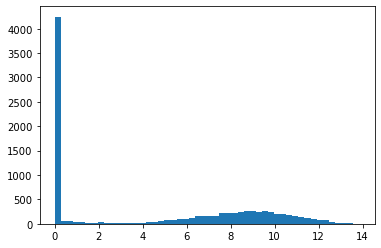

In [15]:
#fit distributionn for feature 8

feature_8 = train_feature_vals_df['feature_8']
feature_8_hist = plt.hist(feature_8, bins=50)
feature_8_hist

#add histogram to hist_dict
hist_dict['feature_8'] = feature_8_hist

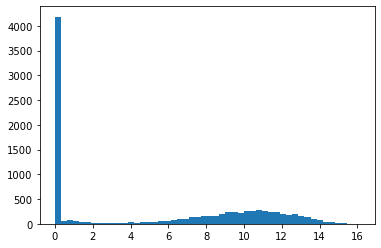

In [16]:
#fit distributionn for feature 9

feature_9 = train_feature_vals_df['feature_9']
feature_9_hist = plt.hist(feature_9, bins=50)
feature_9_hist

#add histogram to hist_dict
hist_dict['feature_9'] = feature_9_hist

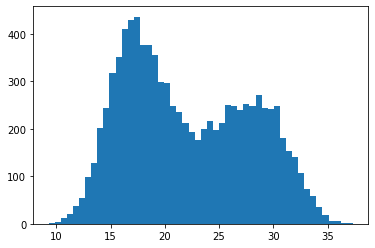

In [17]:
#fit distributionn for feature 10

feature_10 = train_feature_vals_df['feature_10']
feature_10_hist = plt.hist(feature_10, bins=50)
feature_10_hist

#add histogram to hist_dict
hist_dict['feature_10'] = feature_10_hist

# Define Bayesian Model

In [18]:
hist_dict['feature_2'][0]

array([4.163e+03, 7.900e+01, 7.000e+01, 5.500e+01, 3.200e+01, 3.100e+01,
       2.500e+01, 2.100e+01, 2.800e+01, 2.300e+01, 2.100e+01, 1.900e+01,
       2.500e+01, 4.100e+01, 4.900e+01, 6.300e+01, 8.100e+01, 7.200e+01,
       1.140e+02, 1.230e+02, 1.460e+02, 1.530e+02, 1.890e+02, 2.080e+02,
       2.130e+02, 2.430e+02, 2.580e+02, 2.330e+02, 2.850e+02, 2.500e+02,
       2.830e+02, 2.750e+02, 2.390e+02, 2.220e+02, 1.980e+02, 1.920e+02,
       1.560e+02, 1.430e+02, 1.040e+02, 7.600e+01, 5.500e+01, 4.000e+01,
       3.500e+01, 2.100e+01, 1.000e+01, 6.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00])

In [19]:
hist_dict['feature_2'][1]

array([ 0.        ,  0.34998878,  0.69997757,  1.04996635,  1.39995514,
        1.74994392,  2.09993271,  2.44992149,  2.79991028,  3.14989906,
        3.49988785,  3.84987663,  4.19986542,  4.5498542 ,  4.89984299,
        5.24983177,  5.59982056,  5.94980934,  6.29979813,  6.64978691,
        6.9997757 ,  7.34976448,  7.69975327,  8.04974205,  8.39973083,
        8.74971962,  9.0997084 ,  9.44969719,  9.79968597, 10.14967476,
       10.49966354, 10.84965233, 11.19964111, 11.5496299 , 11.89961868,
       12.24960747, 12.59959625, 12.94958504, 13.29957382, 13.64956261,
       13.99955139, 14.34954018, 14.69952896, 15.04951775, 15.39950653,
       15.74949532, 16.0994841 , 16.44947289, 16.79946167, 17.14945045,
       17.49943924])

In [20]:
# define bayesian model
# input: feature values
# output: array of size 10x2 where element i is a size 2 array with values [P(5|f_i), P(8|f_i)]

def bayesian_model(feature_vals):
    
    output = np.empty([10,2])
    
    #define priors
    prior_5 = np.log(0.5)
    prior_8 = np.log(0.5)
    
    for i, val in enumerate(feature_vals):
        
        feature_num = i+1
        
        if feature_num==1 or feature_num==3:
            continue
            
        #get distribution (RV) objects
        dist_5 = feature_dists_5['feature_'+str(feature_num)]
        dist_8 = feature_dists_8['feature_'+str(feature_num)]
        
        #get likelihood (i.e. get log probability of value being between (int(val), int(val)+1))
        log_likelihood_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
        log_likelihood_8 = np.log(dist_8.cdf(int(val)+1) - dist_8.cdf(int(val)))
        
        #get P(f_i)
        hist = hist_dict['feature_'+str(feature_num)]
        hist_counts = hist[0]
        hist_bins = hist[1]
        
        for j, bin_val in enumerate(hist_bins):
            if j == 0:
                continue
            if val <= bin_val:
                log_prob_feature = np.log(hist_counts[j-1] / np.sum(hist_counts))
                break
        
        #compute posteriors
        posterior_5 = np.exp((prior_5 + log_likelihood_5) - log_prob_feature)
        posterior_8 = np.exp((prior_8 + log_likelihood_8) - log_prob_feature)
        
        output[i] = [posterior_5, posterior_8]
    
    return output

# Test Bayesian model

In [21]:
#import cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 10 channels in first convolution layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 20 channels in second conv. layer
        self.fc1 = nn.Linear(320, 10) # 10 hidden units in first fully-connected layer
        self.fc2 = nn.Linear(10, 2) # 2 output units

    def forward(self, x):

        # first convolutional layer
        h_conv1 = self.conv1(x)
        h_conv1 = F.relu(h_conv1)
        h_conv1_pool = F.max_pool2d(h_conv1, 2)

        # second convolutional layer
        h_conv2 = self.conv2(h_conv1_pool)
        h_conv2 = F.relu(h_conv2)
        h_conv2_pool = F.max_pool2d(h_conv2, 2)

        # fully-connected layer
        h_fc1 = h_conv2_pool.view(-1, 320)
        h_fc1 = self.fc1(h_fc1)
        h_fc1 = F.relu(h_fc1)
        
        # classifier output
        output = self.fc2(h_fc1)
        output = F.log_softmax(output,dim=1)
        return output, h_fc1

#load saved trained CNN model
cnn = CNN()
cnn.load_state_dict(torch.load('cnn'))
cnn.train(False)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [22]:
#import test dataset
test_dataset = datasets.MNIST(root='data',
                              train=False,
                              download=True,
                              transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]))

#filter dataset to only 5's and 8's
test_filter = [idx for idx, sample in enumerate(test_dataset) if sample[1] in [5,8]]
test_dataset = torch.utils.data.Subset(test_dataset, test_filter)

In [24]:
#test bayesian model on test set

num_correct = 0

for sample in tqdm(test_dataset):
    data = sample[0]
    label = sample[1]
    
    #extract features using CNN
    output, features = cnn(data)
    
    #get outputs from Bayesian model using extracted features
    bayes_out = bayesian_model(features.squeeze().detach().numpy())
    
    # get prediction by counting predictions by feature
    # if majority of features predict 5 then bayes prediction is 5. If majority predict 8 then bayes prediction is 8
    # in the event of a tie, choose randomly
    
    count_pred_5 = 0
    
    for feature_output in bayes_out:
        prob_5 = feature_output[0]
        prob_8 = feature_output[1]
        
        if prob_5 > prob_8:
            count_pred_5 += 1
    
    if count_pred_5 == 4:
        if random.random() < 0.5:
            bayes_pred = 5
        else:
            bayes_pred = 8
    elif count_pred_5 > 4:
        bayes_pred = 5
    else:
        bayes_pred = 8

    if bayes_pred == label:
        num_correct += 1

#compute test accuracy
test_acc = num_correct / len(test_dataset)

print('bayesian model test accuracy: {}'.format(test_acc))

  0%|          | 7/1866 [00:00<01:10, 26.39it/s]<ipython-input-20-561d9a36d565>:25: RuntimeWarning: divide by zero encountered in log
  log_likelihood_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
100%|██████████| 1866/1866 [00:19<00:00, 94.70it/s] 

bayesian model test accuracy: 0.9758842443729904


In [37]:
out, features = cnn(test_dataset[0][0])
output = bayesian_model(features.squeeze().detach().numpy())
output

array([[0.00000000e+00, 0.00000000e+00],
       [1.12341490e+00, 2.46646178e-04],
       [0.00000000e+00, 0.00000000e+00],
       [1.11760467e+00, 2.60719020e-04],
       [1.14239684e+00, 3.74657611e-04],
       [1.70525061e+00, 1.21827044e-01],
       [1.10808893e+00, 1.51008176e-04],
       [1.10220833e+00, 1.16443760e-04],
       [1.11920685e+00, 2.82312433e-04],
       [1.14219175e+00, 6.40100945e-01]])

# IGNORE BELOW

In [44]:

############ IGNORE THIS CELL ##########################


#define bayesian model
#inputs: feature values
#outputs: P(I|5)*P(5), P(I|8)*P(8)

def bayesian_model_2(feature_vals):
    
    #define priors
    prior_5 = np.log(0.5)
    prior_8 = np.log(0.5)
    
    #compute P(I|C) likelihoods
    likelihood_5 = 0
    likelihood_8 = 0
    
    #compute P(I)
    prob_features = 0
    
    for i, val in enumerate(feature_vals):
        
        feature_num = i+1
        
        if feature_num==1 or feature_num==3:
            continue
            
        #get distribution (RV) objects
        dist_5 = feature_dists_5['feature_'+str(feature_num)]
        dist_8 = feature_dists_8['feature_'+str(feature_num)]
        
        #get log probability of value being between (int(val), int(val)+1)
        log_prob_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
        log_prob_8 = np.log(dist_8.cdf(int(val)+1) - dist_8.cdf(int(val)))
        
        #update likelihoods
        likelihood_5 += log_prob_5
        likelihood_8 += log_prob_8
        
        #get P(f_i)
        hist = hist_dict['feature_'+str(feature_num)]
        hist_counts = hist[0]
        hist_bins = hist[1]
        
        for j, bin_val in enumerate(hist_bins):
            if j == 0:
                continue
            if val <= bin_val:
                log_prob_feature = np.log(hist_counts[j-1] / np.sum(hist_counts))
                prob_features += log_prob_feature
                break
    
    output_5 = np.exp(prior_5 + likelihood_5 - prob_features)
    output_8 = np.exp(prior_8 + likelihood_8 - prob_features)
    
    
    return output_5, output_8
    

In [27]:

############ IGNORE THIS CELL ##########################

#test bayesian model on test set

num_correct = 0

for sample in tqdm(test_dataset):
    data = sample[0]
    label = sample[1]
    
    #extract features using CNN
    output, features = cnn(data)
    
    #get outputs from Bayesian model using extracted features
    bayesian_out_5, bayesian_out_8 = bayesian_model_2(features.squeeze().detach().numpy())
    
    if bayesian_out_5 > bayesian_out_8:
        bayesian_pred = 5
    else:
        bayesian_pred = 8

    if bayesian_pred == label:
        num_correct += 1

#compute test accuracy
test_acc = num_correct / len(test_dataset)

print('bayesian model test accuracy: {}'.format(test_acc))

  0%|          | 0/1866 [00:00<?, ?it/s]<ipython-input-25-e4114a0aeae5>:30: RuntimeWarning: divide by zero encountered in log
  log_prob_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
100%|██████████| 1866/1866 [00:11<00:00, 166.06it/s]

bayesian model test accuracy: 0.9694533762057878


In [43]:

############ IGNORE THIS CELL ##########################

from tqdm import tqdm

comparison_results = []

for sample in tqdm(test_dataset):
    data = sample[0]
    label = sample[1]
    
    #extract features using CNN
    cnn_output, features = cnn(data)
    
    cnn_output = cnn_output.squeeze().detach().numpy()
    
    #get outputs from Bayesian model using extracted features
    bayes_output = bayesian_model_2(features.squeeze().detach().numpy())
    #print(bayes_output)
    bayes_out_softmax = softmax(bayes_output)
    #print(bayes_out_softmax)
    
    if label == 5:
        bayes_result = bayes_out_softmax[0]
        cnn_result = np.exp(cnn_output[0])
    else:
        bayes_result = bayes_out_softmax[1]
        cnn_result = np.exp(cnn_output[1])
    
    
    comparison_results.append((cnn_result, bayes_result))



  0%|          | 4/1866 [00:00<00:51, 36.33it/s]<ipython-input-42-c853956b868b>:30: RuntimeWarning: divide by zero encountered in log
  log_prob_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
  1%|          | 13/1866 [00:00<00:27, 66.20it/s]

-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.314163343778212
-7.109947372020551
-7.9014831049898175
-8.70725057721634
-12.589828763543924
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-5.955951120520593
-6.751735148762933
-7.543270881732199
-8.349038353958722
-11.980877983026208
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.189000200824205
-6.984784229066545
-7.776319962035811
-8.582087434262334
-12.366063643785377
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.366807077263633
-7.162591105505973
-7.954126838475239
-8.759894310701762
-12.642472497029345
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.15344089878772
-6.949224927030059
-7.740760659999325
-8.546528132225848
-12.174343610993608
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-5.516425174339469
-6.312209202581808
-7.103744935551075
-7.909512407777598
-11.179850052158034
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-5.41

  2%|▏         | 29/1866 [00:00<00:25, 71.28it/s]

-3.7425909933601886
-7.975204482856604
-12.150659558513071
-15.334922594122265
-19.779710603562314
-23.720972291717988
-27.624493651890813
-31.27259380183008
-3.8570013445379328
-8.875135334725309
-12.890504995034703
-15.935454418247108
-21.74851828330437
-26.319075680033457
-30.508516997664664
-33.6351921584009
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.366807077263633
-7.162591105505973
-7.954126838475239
-8.759894310701762
-12.606845319386194
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-5.809510579119302
-6.605294607361642
-7.396830340330908
-8.20259781255743
-11.657506733465837
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.617349602765958
-7.413133631008297
-8.204669363977564
-9.010436836204086
-13.118752609022923
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.15344089878772
-6.949224927030059
-7.740760659999325
-8.546528132225848
-12.498839656568105
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.1

  2%|▏         | 46/1866 [00:00<00:24, 73.50it/s]


-12.727029885057409
-0.8112771280374924
-5.91349423543541
-6.739776485275819
-9.814307132505796
-14.785188237842627
-15.576723970811894
-16.38249144303842
-19.59817067488099
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.314163343778212
-7.109947372020551
-7.9014831049898175
-8.70725057721634
-12.472621598908349
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.162212884860556
-6.957996913102895
-7.749532646072161
-8.555300118298684
-12.320671139990692
-3.6238074573702215
-7.05534302709332
-10.745290286968086
-13.79023971018049
-17.352011776631258
-20.963890663136205
-24.556199453447057
-27.84068160521366
-3.80773029553115
-8.225610852051277
-12.542565489981444
-15.617096137211421
-19.765152238679775
-23.847825580885278
-28.117896632916594
-31.33357586475917
-3.4998214775892302
-7.0729358206439334
-10.576297124938288
-13.506957401748563
-17.068729468199333
-20.672734298273376
-24.26504308858423
-27.913143238523496
-0.8112771280374924
-1.6156122772690822
-2

  3%|▎         | 54/1866 [00:00<00:26, 69.59it/s]

-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-5.723531726743861
-6.5193157549862
-7.310851487955467
-8.11661896018199
-11.386956604562428
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-5.419646411453617
-6.2154304396959565
-7.006966172665223
-7.812733644891746
-11.028412876734318
-4.750819220560029
-9.09206655105924
-13.483744735185343
-16.851360787195155
-21.234455227629866
-25.84712410970908
-30.91485504103583
-34.36976396194424
-3.6522069318919193
-7.225321274946623
-10.739377868357725
-13.92364090396692
-17.412917468379536
-21.013008399132442
-24.60531718944329
-27.731992350179524
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.162212884860556
-6.957996913102895
-7.749532646072161
-8.555300118298684
-12.179107575668905
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.189000200824205
-6.984784229066545
-7.776319962035811
-8.582087434262334
-12.205894891632555
-4.775820522765446
-5.580155671997036
-6.406437921837445
-9.6880751

  4%|▍         | 71/1866 [00:01<00:24, 72.53it/s]

-4.33308401986005
-8.454471874246241
-13.035392058010874
-16.08034148122328
-20.46343592165799
-24.55245849154215
-28.687091572678362
-31.971573724444966
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.207265548801499
-7.003049577043838
-7.794585310013105
-8.600352782239627
-12.256683431315409
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.081831366409595
-6.877615394651935
-7.669151127621201
-8.474918599847724
-12.018068154200492
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-5.955951120520593
-6.751735148762933
-7.543270881732199
-8.349038353958722
-12.034721215047032
-3.6688048233009574
-7.530869469795437
-10.985778390703844
-14.030727813916247
-18.227236298770546
-22.034966594301697
-25.699596046192173
-28.826271206928407
-3.8877730032046864
-7.544103652280468
-11.159942940001512
-14.812149871893432
-18.699922875098117
-22.3197383111988
-25.984367763089278
-30.534516288187156
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6

  4%|▍         | 80/1866 [00:01<00:25, 68.97it/s]


-27.094141551119115
-31.170505724131353
-37.750824741902285
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.162212884860556
-6.957996913102895
-7.749532646072161
-8.555300118298684
-12.412301462836616
-3.783976209523043
-7.577386451279445
-11.604661014095157
-14.788924049704352
-18.54056487858446
-22.252111250262686
-26.160937662665205
-29.809037812604473
-3.6942299216667673
-7.367227623227761
-11.057174883102526
-14.400324882957932
-17.9620969494087
-21.581912385509384
-25.174221175820236
-29.47530246459411
-3.7425909933601886
-7.975204482856604
-11.603019961624364
-15.255226893516284
-19.451735378370582
-23.634159123343142
-27.537680483515967
-31.37964395068936
-0.8112771280374924
-1.6156122772690822
-2.4418945271094907
-6.377676749500537
-7.173460777742877
-7.964996510712143
-8.770763982938666
-12.65334216926625
-3.8570013445379328
-7.608642173418039
-11.624011833727433


KeyboardInterrupt: 

In [29]:

############ IGNORE THIS CELL ##########################

comparison_results[:20]

[(0.99962133, 488.800059218479),
 (0.99911803, 57.6611177539668),
 (0.99981815, 881.761151529663),
 (0.9995473, 407.1679166156345),
 (0.9999617, 675.8034213063228),
 (0.9984652, 7.390750229468555),
 (0.9980826, 2.4100541579658334),
 (0.9992155, 242592.10239173888),
 (0.99994487, 268978.10147431155),
 (0.99984145, 922.4777419931474),
 (0.9999723, 249968.2710486638),
 (0.9999247, 879.7467659624922),
 (0.99991953, 936.1182368252445),
 (0.9999995, 204673.06880052856),
 (0.99992263, 954.9915883741413),
 (0.9999105, 870.7276246940714),
 (0.9999995, 512622.90091733995),
 (0.9999997, 319210.39521517715),
 (0.9996928, 644.5793051996939),
 (0.99891, 28.099211767105384)]